In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import torch 
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from typing import Callable
from tqdm import tqdm
from timeit import default_timer as timer
from matplotlib import pyplot as plt
from dataclasses import dataclass
from CommonFunctions import *
%matplotlib inline

In [3]:
data_transform = transforms.Compose([transforms.Resize((28, 28)), transforms.ToTensor()])
train_data = datasets.MNIST(
    root='./data', train=True, download=True, transform=data_transform, target_transform=None
)
test_data = datasets.MNIST(
    root='./data', train=False, download=True, transform=data_transform, target_transform=None
)
len(train_data), len(test_data)

(60000, 10000)

In [4]:
data_classes = train_data.classes
data_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

In [5]:
@dataclass
class LearningParameters:
    batch_size: int = 128
    cpu_count: int = os.cpu_count()
    learning_rate: float = 0.05
    momentum: float = 0.9
    weight_decay: float = 0.05
    epochs: int = 75
    device: torch.device = torch.device('cpu')
    dropout: float = 0.3
    batch_norm: bool = True
params = LearningParameters()

In [6]:
class Deep(nn.Module):
    def __init__(self, dropout: int = 0, add_batch_norm: bool = False):
        super(Deep, self).__init__()
        layer1 = [nn.Linear(in_features=28*28, out_features=20)]
        layer1 += [nn.Dropout(p=dropout)] if dropout > 0 else []
        layer1 += [nn.BatchNorm1d(20)] if add_batch_norm else []
        layer1 += [nn.ReLU()]
        self.layer1 = nn.Sequential(*layer1)
        layer2 = [nn.Linear(in_features=20, out_features=10)]
        layer2 += [nn.Dropout(p=dropout)] if dropout > 0 else []
        layer2 += [nn.BatchNorm1d(10)] if add_batch_norm else []
        layer2 += [nn.LogSoftmax(dim=1)]
        self.layer2 = nn.Sequential(*layer2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.layer2(self.layer1(x.view(-1, 28*28)))

In [7]:
def train_step(model: nn.Module,
               data_loader: DataLoader,
               loss_function: nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_function: Callable,
               device: torch.device = torch.device('cpu')) -> tuple[float:]: 
    train_loss: float = 0
    train_acc: float = 0
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_function(y_pred, y)
        train_loss += loss.item()
        train_acc += accuracy_function(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    return train_loss, train_acc

In [8]:
def test_step(model: nn.Module,
              data_loader: DataLoader,
              loss_function: nn.Module,
              accuracy_function: Callable,
              device: torch.device = torch.device('cpu')) -> tuple[float:]:
    test_loss: float = 0
    test_acc: float = 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_function(test_pred, y).item()
            test_acc += accuracy_function(y, test_pred.argmax(dim=1))
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
    return test_loss, test_acc

In [9]:
def accuracy_fn(y_true, y_pred):
    return (torch.eq(y_true, y_pred).sum().item() / len(y_pred)) * 100

In [10]:
def plot_loss_and_accuracy(model, epochs, train_loss_list, train_acc_list, test_loss_list, test_acc_list):
    with plt.style.context('cyberpunk'):
        figure, axes = plt.subplots(2, 1, layout='constrained', figsize=(8, 6))
        axes[0].plot(range(1, epochs + 1), train_loss_list, label='Train')
        axes[0].plot(range(1, epochs + 1), test_loss_list, label='Test')
        axes[0].set(ylabel='Loss', title=f'Loss Function and Accuracy for {model.__class__.__name__}')
        axes[0].legend()
        enhance_plot(figure, axes[0], glow=True)
        axes[1].plot(range(1, epochs + 1), train_acc_list, label='Train')
        axes[1].plot(range(1, epochs + 1), test_acc_list, label='Test')
        axes[1].set(xlabel='epoch', ylabel='Accuracy')
        axes[1].legend()
        enhance_plot(figure, axes[1], glow=True)
        return figure, axes

In [11]:
loader_kwargs = dict(batch_size=params.batch_size, pin_memory=True, num_workers=params.cpu_count)
train_loader = DataLoader(train_data, **loader_kwargs, shuffle=True)
test_loader = DataLoader(test_data, **loader_kwargs, shuffle=False)
len(train_data), len(test_data), len(train_loader)

(60000, 10000, 469)

In [12]:
model1 = Deep().to(params.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model1.parameters(), lr=params.learning_rate, momentum=params.momentum)
model1

Deep(
  (layer1): Sequential(
    (0): Linear(in_features=784, out_features=20, bias=True)
    (1): ReLU()
  )
  (layer2): Sequential(
    (0): Linear(in_features=20, out_features=10, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [13]:
train_time_start = timer()
train_loss, train_acc = [], []
test_loss, test_acc = [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        model1, train_loader, loss_fn, optimizer, accuracy_fn, params.device
    )
    test_metrics = test_step(model1, test_loader, loss_fn, accuracy_fn, params.device)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])
    test_loss.append(test_metrics[0])
    test_acc.append(test_metrics[1])
train_time_end = timer()
f'Time: {train_time_end - train_time_start:.3f} seconds'

100%|██████████| 2/2 [00:27<00:00, 13.65s/it]


'Time: 27.307 seconds'

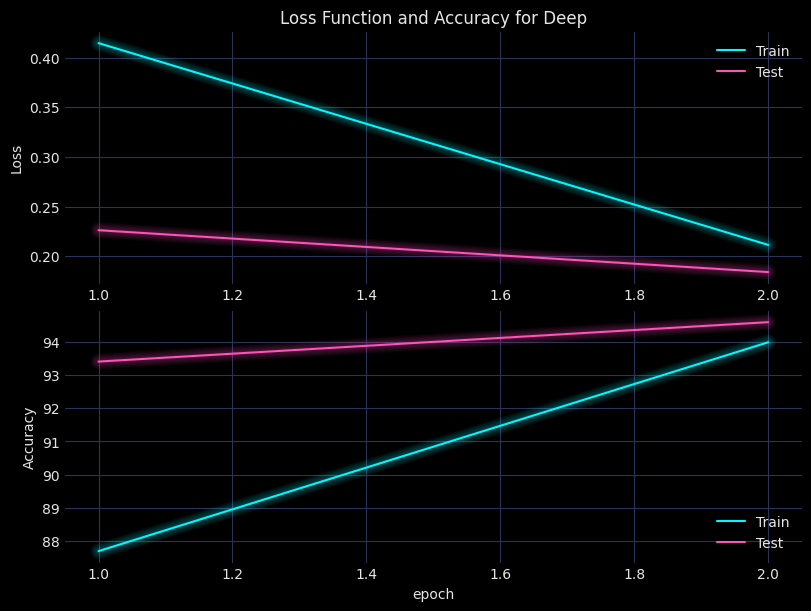

In [14]:
plot_loss_and_accuracy(model1, params.epochs, train_loss, train_acc, test_loss, test_acc);

## Adding L2 regularization (weight decay)

In [15]:
model2 = Deep().to(params.device)
optimizer = torch.optim.SGD(model2.parameters(), 
                            lr=params.learning_rate, 
                            momentum=params.momentum, 
                            weight_decay=params.weight_decay)
train_time_start = timer()
train_loss, train_acc = [], []
test_loss, test_acc = [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        model2, train_loader, loss_fn, optimizer, accuracy_fn, params.device
    )
    test_metrics = test_step(model2, test_loader, loss_fn, accuracy_fn, params.device)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])
    test_loss.append(test_metrics[0])
    test_acc.append(test_metrics[1])
train_time_end = timer()
f'Time: {train_time_end - train_time_start:.3f} seconds'

100%|██████████| 2/2 [00:27<00:00, 13.74s/it]


'Time: 27.477 seconds'

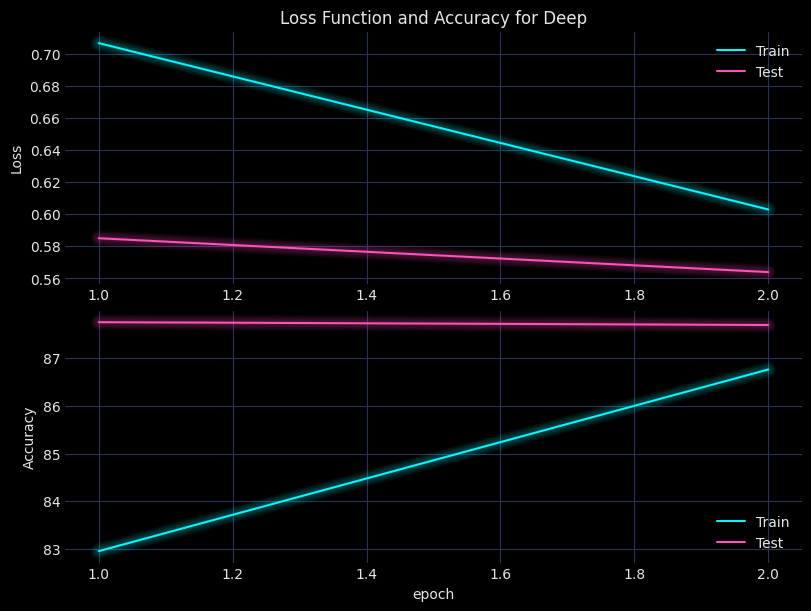

In [16]:
plot_loss_and_accuracy(model2, params.epochs, train_loss, train_acc, test_loss, test_acc);

## Dropout

In [17]:
model3 = Deep(dropout=params.dropout).to(params.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model3.parameters(), 
                            lr=params.learning_rate, 
                            momentum=params.momentum)

In [18]:
train_time_start = timer()
train_loss, train_acc = [], []
test_loss, test_acc = [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        model3, train_loader, loss_fn, optimizer, accuracy_fn, params.device
    )
    test_metrics = test_step(model3, test_loader, loss_fn, accuracy_fn, params.device)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])
    test_loss.append(test_metrics[0])
    test_acc.append(test_metrics[1])
train_time_end = timer()
f'Time: {train_time_end - train_time_start:.3f} seconds'

100%|██████████| 2/2 [00:27<00:00, 13.57s/it]


'Time: 27.135 seconds'

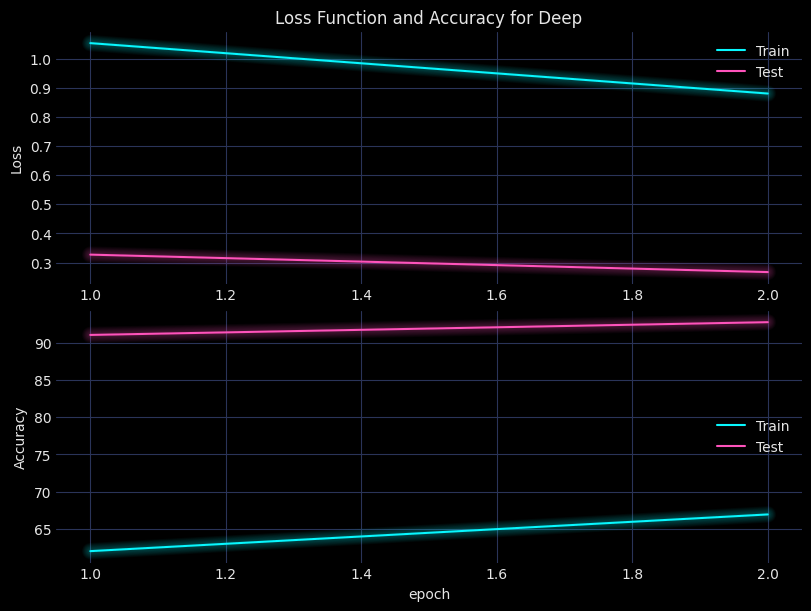

In [19]:
plot_loss_and_accuracy(model3, params.epochs, train_loss, train_acc, test_loss, test_acc);

## Batch Normalization

In [20]:
model4 = Deep(dropout=params.dropout).to(params.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model4.parameters(), 
                            lr=params.learning_rate, 
                            momentum=params.momentum)

In [21]:
train_time_start = timer()
train_loss, train_acc = [], []
test_loss, test_acc = [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        model4, train_loader, loss_fn, optimizer, accuracy_fn, params.device
    )
    test_metrics = test_step(model4, test_loader, loss_fn, accuracy_fn, params.device)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])
    test_loss.append(test_metrics[0])
    test_acc.append(test_metrics[1])
train_time_end = timer()
f'Time: {train_time_end - train_time_start:.3f} seconds'

100%|██████████| 2/2 [00:26<00:00, 13.49s/it]


'Time: 26.981 seconds'

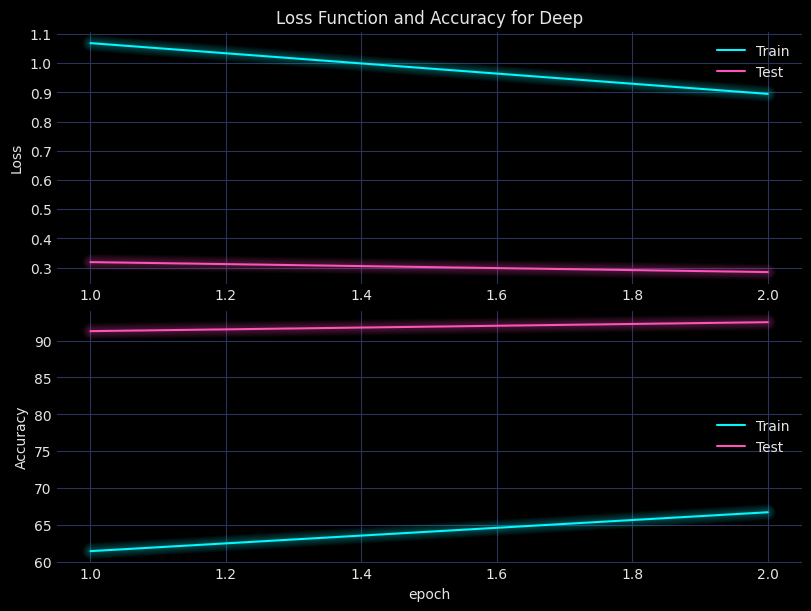

In [22]:
plot_loss_and_accuracy(model4, params.epochs, train_loss, train_acc, test_loss, test_acc);

## Data Augmentation

* Random rotation by 10 degrees
* Random zoom by 10 %
* Random shift by 10 % (horizontal and vertical)
* Random shear by 10 %

In [23]:
data_transform = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.RandomAffine(degrees=10,
                            translate=(0.1, 0.1),
                            scale=(1, 1.1),
                            shear=10),
    transforms.ToTensor()
])
train_data = datasets.MNIST(
    root='./data', train=True, download=True, transform=data_transform, target_transform=None
)
train_loader = DataLoader(train_data, **loader_kwargs, shuffle=True)

In [24]:
model5 = Deep(add_batch_norm=params.batch_norm).to(params.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(
    model5.parameters(), lr=params.learning_rate, momentum=params.momentum)

In [25]:
train_time_start = timer()
train_loss, train_acc = [], []
test_loss, test_acc = [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        model5, train_loader, loss_fn, optimizer, accuracy_fn, params.device
    )
    test_metrics = test_step(model5, test_loader, loss_fn, accuracy_fn, params.device)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])
    test_loss.append(test_metrics[0])
    test_acc.append(test_metrics[1])
train_time_end = timer()
f'Time: {train_time_end - train_time_start:.3f} seconds'

100%|██████████| 2/2 [00:29<00:00, 14.81s/it]


'Time: 29.615 seconds'

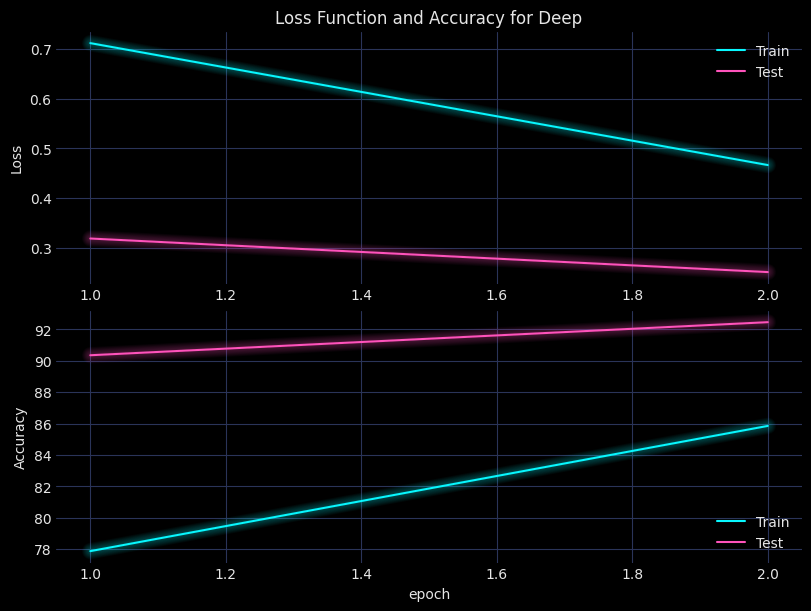

In [26]:
plot_loss_and_accuracy(model5, params.epochs, train_loss, train_acc, test_loss, test_acc);

## All regularizations combined

In [27]:
model6 = Deep(dropout=params.dropout, add_batch_norm=params.batch_norm).to(params.device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model6.parameters(), 
                            lr=params.learning_rate, 
                            momentum=params.momentum,
                            weight_decay=params.weight_decay)

In [28]:
train_time_start = timer()
train_loss, train_acc = [], []
test_loss, test_acc = [], []
for epoch in tqdm(range(params.epochs)):
    train_metrics = train_step(
        model6, train_loader, loss_fn, optimizer, accuracy_fn, params.device
    )
    test_metrics = test_step(model6, test_loader, loss_fn, accuracy_fn, params.device)
    train_loss.append(train_metrics[0])
    train_acc.append(train_metrics[1])
    test_loss.append(test_metrics[0])
    test_acc.append(test_metrics[1])
train_time_end = timer()
f'Time: {train_time_end - train_time_start:.3f} seconds'

100%|██████████| 2/2 [00:28<00:00, 14.47s/it]


'Time: 28.949 seconds'

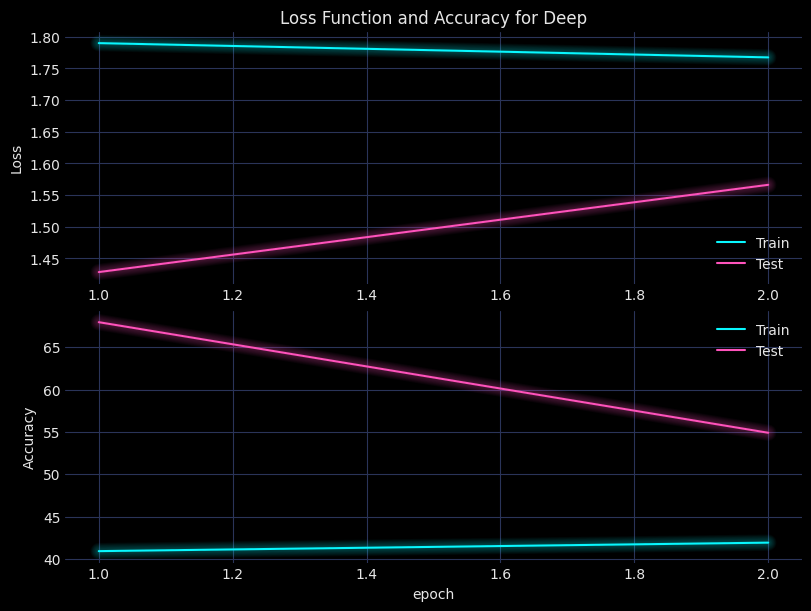

In [29]:
plot_loss_and_accuracy(model6, params.epochs, train_loss, train_acc, test_loss, test_acc);